In [1]:
import numpy as np
import sklearn.linear_model as linear
import sklearn.model_selection as selection
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn import metrics

import torch as th
import torch.nn as nn
import torch.optim as optim
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
databasePath = "../eICU/training/"
exportPath = "../eICU/training/"

In [3]:
finalFeatures = pd.read_csv(databasePath + '/finalFeatures.csv')
finalFeatures = finalFeatures.fillna(0) # fills nan from kurtosis and skew
finalFeatures

,patientid,temperature_min,temperature_max,temperature_mean,temperature_std,temperature_kurtosis,temperature_skew,temperature_median,heartrate_min,heartrate_max,...,creatinine_skew,creatinine_median,urineoutputbyweight_min,urineoutputbyweight_max,urineoutputbyweight_mean,urineoutputbyweight_std,urineoutputbyweight_kurtosis,urineoutputbyweight_skew,urineoutputbyweight_median,diagnosis
0,1412030,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,68.0,120.0,...,-1.4140,0.6875,6.9586,6.9586,6.9586,0.0000,0.0000,0.0000,6.9586,0.0
1,1412271,37.6965,38.1204,38.0819,0.1278,11.0000,-3.3166,38.1204,103.0,112.0,...,0.2131,1.4000,2.4331,2.4331,2.4331,0.0000,0.0000,0.0000,2.4331,1.0
2,1412290,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,57.0,75.0,...,0.1274,1.2345,4.4543,4.4543,4.4543,0.0000,0.0000,0.0000,4.4543,0.0
3,1412660,37.4000,38.0000,37.7832,0.1822,-0.3726,-0.6013,37.8000,84.0,109.0,...,-0.5963,1.6136,0.8306,3.7375,3.6347,0.4814,21.5211,-4.7383,3.7375,0.0
4,1412840,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,70.0,106.0,...,-0.0575,1.0584,0.6420,1.7976,1.5475,0.2748,2.0620,-1.6282,1.5956,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406022,33532516,32.2000,37.7000,35.3112,2.1057,-1.7574,-0.2178,36.6000,51.0,104.0,...,-0.0645,2.6469,0.0980,5.6373,1.0889,0.9895,3.4195,1.6831,0.8171,1.0
406023,33532517,32.2000,37.4000,34.5467,1.8862,-1.7703,0.2656,33.4000,51.0,104.0,...,0.1481,2.5493,0.0980,5.6373,0.9832,1.0570,3.9619,1.9491,0.6334,1.0
406024,33532518,32.2000,36.8000,34.1643,1.7398,-1.4068,0.6213,33.1000,60.0,104.0,...,0.0064,2.4888,0.0980,5.6373,1.0385,1.1231,2.9569,1.7434,0.6010,1.0
406025,33532540,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,72.0,83.0,...,-2.1039,2.2769,0.3576,19.0703,3.7475,2.6719,13.1009,3.2470,2.3838,0.0


#### Cleaning data and Sorting to Input and Target Arrays

In [4]:
x = [] # input (attributes)
y = [] # output (targets)

x = finalFeatures.iloc[:, 1:57].values
y = finalFeatures.iloc[:, 57].values


#### Setting up Models for Neural Network

In [5]:
class MoonModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_func = nn.BCELoss()

    def forward(self, x):
        return None

    def loss(self, x, y):
        probs = self.forward(x)
        return self.loss_func(probs, y)

    def predict_proba(self, x, as_numpy=False):
        res = self.forward(x)
        if as_numpy:
            res = res.cpu().detach().numpy()
        return res

    def predict(self, x, threshold=0.5, as_numpy=False):
        probs = self.predict_proba(x, as_numpy)
        return probs > threshold

    def fit(self, x_train, x_test, y_train, y_test, epochs=1000, lr=0.1, lam=0):
        optimizer = optim.RMSprop(self.parameters(), lr=lr)
        train_loss_curve = []
        test_loss_curve = []
        for epoch in range(epochs):
            optimizer.zero_grad()
            train_loss_val = self.loss(x_train, y_train) + self.regularize(lam)
            train_loss_curve.append(train_loss_val.data.item())
            train_loss_val.backward()
            optimizer.step()
            
            test_loss_val = self.loss(x_test, y_test) + self.regularize(lam)
            test_loss_curve.append(test_loss_val.data.item())
            
            if epoch % 500 == 0:
                print(f'Epoch {epoch}, Train Loss: {train_loss_val:.5f}, Test Loss: {test_loss_val:.5f}')
            
            
        return train_loss_curve, test_loss_curve

    def regularize(self, lam):
        loss_val = 0
        for p in self.parameters():
            loss_val += lam * th.norm(p)
        return loss_val

In [6]:
# class NNModel(MoonModel):
#     def __init__(self):
#         super().__init__()
#         self.l1 = nn.Linear(56, 224, bias=True)
#         self.act1 = nn.PReLU()
#         self.l2 = nn.Linear(224, 1, bias=True)
#         self.act2 = nn.Sigmoid()

#     def get_intermediary(self, x):
#         res = self.l1(x)
#         res = self.act1(res)
#         return res

#     def forward(self, x):
#         res = self.l1(x)
#         res = self.act1(res)
#         res = self.l2(res)
#         res = self.act2(res)
#         return res

class NNModel(MoonModel):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(56, 113, bias=True)
        self.act1 = nn.PReLU()
        self.l2 = nn.Linear(113, 56, bias=True)
        self.act2 = nn.PReLU()
        self.l3 = nn.Linear(56, 1, bias=True)
        self.act3 = nn.Sigmoid()

    def get_intermediary(self, x):
        res = self.l1(x)
        res = self.act1(res)
        res = self.l2(res)
        res = self.act2(res)

        return res

    def forward(self, X):
        res = self.get_intermediary(X)
        res = self.l3(res)
        res = self.act3(res)
        return res

#### Applying Logistic Regression and Neural Network Model

In [7]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
kf = selection.KFold(n_splits=2, shuffle=True)
kf.get_n_splits(x)

f1_lr = []
f1_nn = []

precision_lr = []
precision_nn = []

accuracy_lr = []
accuracy_nn = []

recall_lr = []
recall_nn = []

train_curve = []
test_curve = []




for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


    lr = linear.LogisticRegression(solver='lbfgs')
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_test)
    probs = lr.predict_proba(X_test)[:,1]
    
    f1_lr.append(metrics.f1_score(y_test, predictions))
    precision_lr.append(metrics.precision_score(y_test, predictions))
    accuracy_lr.append(metrics.accuracy_score(y_test, predictions))
    recall_lr.append(metrics.recall_score(y_test, predictions))

    X_train = th.tensor(X_train, dtype=th.float32)
    X_test = th.tensor(X_test, dtype=th.float32)
    y_train = th.tensor(y_train, dtype=th.float32).view(-1, 1)
    y_test = th.tensor(y_test, dtype=th.float32).view(-1, 1)

    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    nn1 = NNModel()
    nn1.to(device)

    train_loss, test_loss = nn1.fit(X_train, X_test, y_train, y_test, epochs=4000, lr=0.0002, lam=0.0001)
    
    train_curve.append(train_loss)
    test_curve.append(test_loss)
    
    predictions = nn1.predict(X_test, as_numpy=True)
    probs = nn1.predict_proba(X_test, as_numpy=True)
    
    f1_nn.append(metrics.f1_score(y_test.cpu(), predictions))
    precision_nn.append(metrics.precision_score(y_test.cpu(), predictions))
    accuracy_nn.append(metrics.accuracy_score(y_test.cpu(), predictions))
    recall_nn.append(metrics.recall_score(y_test.cpu(), predictions))

Epoch 0, Train Loss: 0.68921, Test Loss: 0.68183
Epoch 500, Train Loss: 0.33509, Test Loss: 0.33678
Epoch 1000, Train Loss: 0.23780, Test Loss: 0.24012
Epoch 1500, Train Loss: 0.19531, Test Loss: 0.19762
Epoch 2000, Train Loss: 0.17396, Test Loss: 0.17760
Epoch 2500, Train Loss: 0.16134, Test Loss: 0.16395
Epoch 3000, Train Loss: 0.15250, Test Loss: 0.15130
Epoch 3500, Train Loss: 0.14360, Test Loss: 0.14195
Epoch 0, Train Loss: 0.68133, Test Loss: 0.67457
Epoch 500, Train Loss: 0.35087, Test Loss: 0.34790
Epoch 1000, Train Loss: 0.24397, Test Loss: 0.24309
Epoch 1500, Train Loss: 0.19868, Test Loss: 0.19670
Epoch 2000, Train Loss: 0.17951, Test Loss: 0.17878
Epoch 2500, Train Loss: 0.16562, Test Loss: 0.16599
Epoch 3000, Train Loss: 0.15664, Test Loss: 0.16129
Epoch 3500, Train Loss: 0.15111, Test Loss: 0.15551


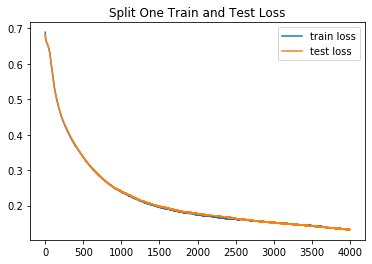

In [10]:
plt.plot(train_curve[0], label='train loss')
plt.plot(test_curve[0], label='test loss')
plt.legend()
plt.title('Split One Train and Test Loss')
plt.show()

In [11]:
def plot_loss(loss_curve, x):
    plt.plot(list(range(len(loss_curve))), loss_curve, label=f'Split {x+1}')

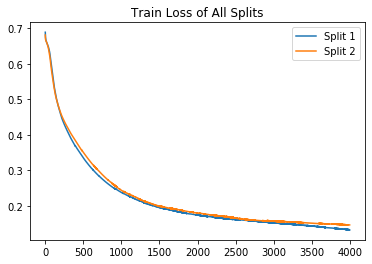

In [12]:
for x, curve in enumerate(train_curve):
    plot_loss(curve, x)

plt.legend()
plt.title('Train Loss of All Splits')
plt.show()

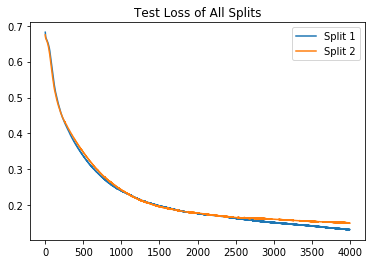

In [13]:
for x, curve in enumerate(test_curve):
    plot_loss(curve, x)

plt.legend()
plt.title('Test Loss of All Splits')
plt.show()

#### Comparing Statistical Results for the Models

In [14]:
print("Logistic Regression Model F1 Score Mean: ", np.mean(f1_lr))
print("Logistic Regression Model F1 Score Standard Deviation: ", np.std(f1_lr), '\n')

print("Logistic Regression Model Precision Score Mean: ", np.mean(precision_lr))
print("Logistic Regression Model Precision Score Standard Deviation: ", np.std(precision_lr), '\n')

print("Logistic Regression Model Accuracy Score Mean: ", np.mean(accuracy_lr))
print("Logistic Regression Model Accuracy Score Standard Deviation: ", np.std(accuracy_lr), '\n')

print("Logistic Regression Model Recall Score Mean: ", np.mean(recall_lr))
print("Logistic Regression Model Recall Score Standard Deviation: ", np.std(recall_lr))

Logistic Regression Model F1 Score Mean:  0.9412712484748664
Logistic Regression Model F1 Score Standard Deviation:  0.0005161432033767288 

Logistic Regression Model Precision Score Mean:  0.9683204289862448
Logistic Regression Model Precision Score Standard Deviation:  0.00020932692548075726 

Logistic Regression Model Accuracy Score Mean:  0.9562048840302202
Logistic Regression Model Accuracy Score Standard Deviation:  0.00044813819003181043 

Logistic Regression Model Recall Score Mean:  0.915692377438324
Logistic Regression Model Recall Score Standard Deviation:  0.0007897525441664666


In [15]:
print("Neural Network Model F1 Score Mean: ", np.mean(f1_nn))
print("Neural Network Model F1 Score Standard Deviation: ", np.std(f1_nn), '\n')

print("Neural Network Model Precision Score Mean: ", np.mean(precision_nn))
print("Neural Network Model Precision Score Standard Deviation: ", np.std(precision_nn), '\n')

print("Neural Network Model Accuracy Score Mean: ", np.mean(accuracy_nn))
print("Neural Network Model Accuracy Score Standard Deviation: ", np.std(accuracy_nn), '\n')

print("Neural Network Model Recall Score Mean: ", np.mean(recall_nn))
print("Neural Network Model Recall Score Standard Deviation: ", np.std(recall_nn))

Neural Network Model F1 Score Mean:  0.9461056103261991
Neural Network Model F1 Score Standard Deviation:  0.00033508551628042005 

Neural Network Model Precision Score Mean:  0.9735985859641445
Neural Network Model Precision Score Standard Deviation:  0.0002679643113752128 

Neural Network Model Accuracy Score Mean:  0.9598228685401191
Neural Network Model Accuracy Score Standard Deviation:  0.0001552610470029192 

Neural Network Model Recall Score Mean:  0.9201233838130704
Neural Network Model Recall Score Standard Deviation:  0.0008732035679369643


In [62]:
print("T-Test comparing the Logistic Regression and the Neural Network Models: ")
print(stats.ttest_rel(f1_lr, f1_nn))

T-Test comparing the Logistic Regression and the Neural Network Models: 
Ttest_relResult(statistic=7.219253995145516, pvalue=0.08762599698786022)


Using a significance level of 0.05, we see that the difference between logistic regression
and neural network are not statistically significant.

#### Intermediary Workings of the Neural Network

In [ ]:
X_transformed = th.tensor(x, dtype=th.float32)
representations = nn1.get_intermediary(X_transformed)
representations = representations.detach().numpy()

In [ ]:
colors = np.array(['tab:red' if cl == 0 else 'tab:blue' for cl in y])
plt.scatter(representations[:,0], representations[:,1], c=colors)